In [64]:
# --- Ottimizzazione ---
# La libreria fondamentale per interagire con il solutore Gurobi
import gurobipy as gp
from gurobipy import GRB

# --- Gestione Dati e Calcolo Numerico ---
# Per leggere e manipolare dati in tabelle (DataFrame)
import pandas as pd
# Per calcoli numerici efficienti, specialmente con array
import numpy as np

# --- Visualizzazione dei Risultati ---
# La libreria base per creare grafici e plot
import matplotlib.pyplot as plt
# Un'estensione di matplotlib per grafici statistici più belli
import seaborn as sns

import time

# --- Utilità per Grafi e Barre di Avanzamento ---
# Per creare e manipolare la rete di aeroporti
import networkx as nx
# Per mostrare barre di avanzamento durante i calcoli lunghi (molto comodo!)
from tqdm.notebook import tqdm

# --- Impostazioni Aggiuntive (Opzionale) ---
# Per rendere i grafici di seaborn più belli
sns.set_theme(style="whitegrid")
# Per evitare che pandas mostri i numeri in notazione scientifica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

print("Librerie importate con successo!")

Librerie importate con successo!


In [ ]:

# Funzioni dai file .py nella cartella utilis/
from utilis.init_dataset import (cells_generation, nodes_generation, get_pop_cells_near_airports, 
                                 get_pop_density, nodes_distances, grid_dimensions)
from utilis.preprocessing import create_threshold_graph
from utilis.init_model import get_all_simple_path_to_destinations, get_pop_paths
from utilis.plot import plot_dataset 

sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: f'{x:.5f}')

print("Moduli del progetto importati con successo!")

Moduli del progetto importati con successo!


### PREPARAZIONE DATI PER IL MODELLO TRAMITE MODULI ###
Generazione dati in corso...
La cella di destinazione 76 è servita dagli aeroporti: [3, 5]
Generati 26 possibili percorsi di volo verso le destinazioni.
Associazione tra celle di popolazione e percorsi completata.


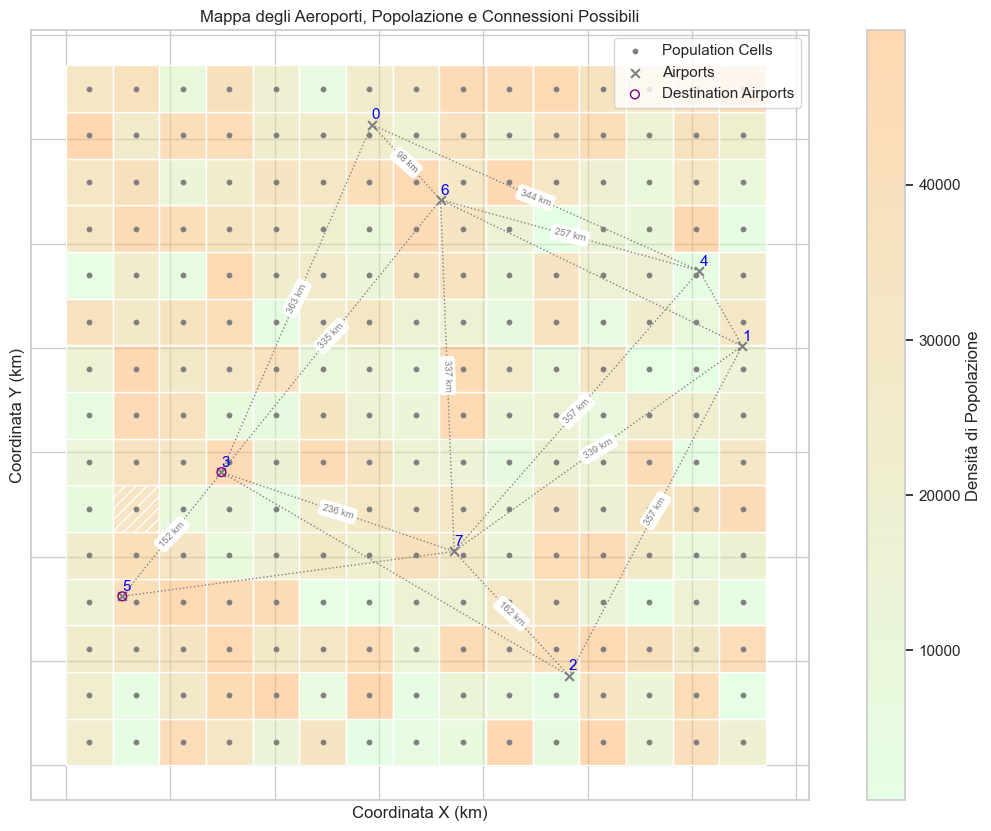

In [ ]:
# ===================================================================
# FASE : FUNZIONE DI SUPPORTO PER IL RAFFORZAMENTO (Sezione 3.1.1)
# ===================================================================

# --- 1. Parametri di Generazione (presi da test.py) ---
np.random.seed(67) # Usiamo un seed per la riproducibilità
num_pop_cells_x = 15
num_pop_cells_y = 15
pop_cell_area = 2000
numero_pop_cells = num_pop_cells_y * num_pop_cells_x

numero_aeroporti = 8
tau = 400
max_path_len = 3
max_ground_distance = 90 # Distanza massima (in km) tra cella di popolazione e aeroporto

destination_cell = 61 + 15 # 61 single destination ariport, 61 + 15 multi destination airport

# --- 2. Generazione dei Dati chiamando le funzioni da utilis/ ---
print("Generazione dati in corso...")

pop_coords = cells_generation(num_pop_cells_x, num_pop_cells_y, pop_cell_area)
population_df = pd.DataFrame({
    'id': range(numero_aeroporti, numero_aeroporti + numero_pop_cells),
    'type': 'population', 'x': pop_coords[:, 0], 'y': pop_coords[:, 1],
    'population': get_pop_density(pop_coords)
})

total_width, total_height = grid_dimensions(num_pop_cells_x, num_pop_cells_y, pop_cell_area)
airport_coords = nodes_generation(numero_aeroporti, total_width, total_height)
airports_df = pd.DataFrame({
    'id': range(numero_aeroporti), 'type': 'airport', 'x': airport_coords[:, 0], 'y': airport_coords[:, 1], 'population': 0
})

airports = airports_df['id'].tolist()
dist_dict = nodes_distances(airport_coords)
dist_matrix = np.array([[dist_dict.get((i, j), dist_dict.get((j, i), 0)) for j in airports] for i in airports])

G = create_threshold_graph(dist_dict, tau)

# --- DETERMINA GLI AEROPORTI DI DESTINAZIONE IN BASE ALLA CELLA ---
pop_cells_near_airports = get_pop_cells_near_airports(airport_coords, pop_coords, max_ground_distance)
destination_airports = [airport_id for airport_id, near_cells in pop_cells_near_airports.items() if destination_cell in near_cells]

print(f"La cella di destinazione {destination_cell} è servita dagli aeroporti: {destination_airports}")

# --- 3. Generazione dei Percorsi ---
all_paths = get_all_simple_path_to_destinations(G, destination_airports, max_path_len)
print(f"Generati {len(all_paths)} possibili percorsi di volo verso le destinazioni.")

pop_to_airport_paths = get_pop_paths(pop_coords, all_paths, pop_cells_near_airports)
print("Associazione tra celle di popolazione e percorsi completata.")

# --- 4. Visualizzazione Setup ---
plot_dataset(
    pop_coords=pop_coords, pop_density=population_df['population'].values, airports_coords=airport_coords,
    airport_distances=dist_dict, graph_below_tau=G, destination_airports=destination_airports,
    destination_cell=destination_cell
)
plt.show()

In [67]:
# ===================================================================
# FASE 2.5: FUNZIONE DI SUPPORTO PER IL RAFFORZAMENTO (Sezione 3.1.1)
# ===================================================================

def calculate_tight_big_m(airports_df, dist, G, tau):
    """
    Calcola i valori "stretti" per i parametri Big-M come descritto
    nella Sezione 3.1.1 del paper.
    """
    print("\nCalcolo dei parametri Big-M stretti...")
    
    airports = airports_df['id'].tolist()
    
    # Calcolo di M1 (un valore per ogni aeroporto, come da Formula 17)
    M1_vals = {}
    for i in airports:
        neighbors = list(G.neighbors(i))
        if not neighbors: # Areoporto è isolato, non ha nessun vicino a distanza < tau
            M1_vals[i] = 0 # Impostare M1_vals[i] = 0 è un modo efficiente per "comunicare" questa informazione al modello. Quando Gurobi vedrà questo valore, il vincolo rho[i] <= 0 * (1 - y[i]) forzerà rho_i a essere 0
        else:
            min_dist_to_neighbor = min(dist[i, j] for j in neighbors)
            # Questa è l'implementazione della logica della Proposizione 2
            M1_vals[i] = tau - min_dist_to_neighbor + 0.001 # + un piccolo epsilon

    # Calcolo di M2 e M3 (un valore per ogni tratta)
    M2_vals = {}
    M3_vals = {}
    for i, j in G.edges():
        edge = tuple(sorted((i,j)))
        
        # Prepara i dati per le formule
        neighbors_i = list(G.neighbors(i)) # N_i
        neighbors_j = list(G.neighbors(j)) # N_j

        # Calcolo M2 (Formula 18)
        if not neighbors_j:
            min_dist_from_j = 0 # Se la lista neighbors_j è vuota, il codice esegue min_dist_from_j = 0 e non prova a calcolare la min_dist_from_j che darebbe errore!
        else:
            min_dist_from_j = min(dist[j, r] for r in neighbors_j)
        M2_vals[edge] = dist[i,j] + tau - min_dist_from_j + 0.001

        # Calcolo M3 (Formula 19)
        if not neighbors_i:
            min_dist_from_i = 0 # Stessa cosa di sopra
        else:
            min_dist_from_i = min(dist[i, r] for r in neighbors_i)
        M3_vals[edge] = dist[i,j] + tau - min_dist_from_i - min_dist_from_j + 0.002
            
    print("Calcolo Big-M completato.")
    return M1_vals, M2_vals, M3_vals

In [68]:
# ======================================================================
# Modello EACN-REG Completo (CON RAFFORZAMENTO TOTALE della Sezione 3.1)
# ======================================================================

# --- 1. Parametri e Dati ---
mu1 = 10000
mu2 = 10000

airports = airports_df['id'].tolist() # Estrea indice degli aeroporti 0, 1, ..
coords = airports_df[['x', 'y']].to_numpy() # Estrae coordinate x e y degli aeroporti
dist = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2) # Tabella distanze tra aeroporti, distanza ii è zero -> diagonale nulla

# <<< Sezione 3.1.1: Valori big-M Ristretti >>>
M1_vals, M2_vals, M3_vals = calculate_tight_big_m(airports_df, dist, G, tau)
# <<< Fine Sezione 3.1.1 >>>

# --- 2. Creazione del Modello Gurobi ---
m = gp.Model("EACN_REG_Strengthened_Full")

# --- 3. Variabili di Decisione ---
y = m.addVars(airports, vtype=GRB.BINARY, name="y")
rho = m.addVars(airports, vtype=GRB.CONTINUOUS, name="rho", lb=0.0) # lb -> lower bound, lb=0.0 per porre il vicolo rho[i] >= 0, come da vincolo (7)
w = m.addVars([(i, j) for i in airports for j in G.neighbors(i)], vtype=GRB.BINARY, name="w") # -> Correzione chagpt
chi = m.addVars(airports, vtype=GRB.BINARY, name="chi")

#  Creiamo un elenco di tratte "canoniche" (ordinate)
canonical_edges = sorted(list(set(tuple(sorted(edge)) for edge in G.edges())))

# Serve per la variabile z_ij = z_ji
# La variabile z_ij è una variabile binaria che rappresenta la fattibilità strategica di una tratta di volo da i a j.
# Questo "interruttore" si può accendere (z_ij = 1) se e solo se un aereo può completare l'intero ciclo di missione che passa per quella tratta, ovvero:
# - Partire da una base di ricarica e arrivare all'aeroporto i (costo in autonomia: rho_i).
# - Effettuare il volo da i a j (costo in autonomia: d_ij).
# - Avere abbastanza autonomia residua per poter raggiungere da j la successiva base di ricarica (costo in autonomia: rho_j).
# Dire che tratta (i,j) è fattibile è come dire che (j,i) è fattibile! Con una ragionevole assunzione che d_ij = d_ji

z = m.addVars(canonical_edges, vtype=GRB.BINARY, name="z")

# --- VECCHIO CODICE --- -> Prima del rilassamento lineare
# psi = m.addVars(len(all_paths), vtype=GRB.BINARY, name="psi")
# phi = m.addVars(population_df['id'], vtype=GRB.BINARY, name="phi")

# <<<  Sezione 3.1.3: Rilassamento Binario per psi e phi >>>
psi = m.addVars(len(all_paths), vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="psi")
phi = m.addVars(population_df['id'], vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="phi")
# <<< Fine Sezione 3.1.3 >>>

# --- 4. Funzione Obiettivo ---
population_covered = gp.quicksum(phi[k] * population_df.set_index('id').loc[k, 'population'] for k in population_df['id'])
installation_cost = gp.quicksum(y[i] for i in airports)
m.setObjective(mu1 * population_covered - mu2 * installation_cost, GRB.MAXIMIZE)

# --- 5. Vincoli --- 
# Vincolo (3) - Proposizione 1
for i in airports:
    neighbors = list(G.neighbors(i))
    m.addConstr(rho[i] <= M1_vals[i] * (1 - y[i])) # Vincolo (12) con M1 stretto
    m.addConstr(y[i] + gp.quicksum(w.get((i,j), 0) for j in neighbors) + chi[i] == 1) # Vincolo (16)
    m.addConstr(rho[i] >= M1_vals[i] * chi[i]) # Vincolo (15) con M1 stretto
    for j in neighbors:
        edge = tuple(sorted((i,j)))
        m.addGenConstrIndicator(w.get((i,j),0), 1, rho[i] <= dist[i, j] + rho[j]) # Vincolo (13) -> modifica proposta da chatgpt
        m.addConstr(rho[i] >= dist[i, j] + rho[j] - M2_vals[edge] * (1 - w.get((i,j), 0))) # Vincolo (14) con M2 stretto
        
# Vincolo (4): Fattibilità delle tratte z_ij
for i, j in canonical_edges:
    m.addConstr(dist[i, j] + rho[i] + rho[j] <= tau + M3_vals[i,j] * (1 - z[i,j])) # Vincolo (4) con M3 stretto

# <<< Vincoli di Sezione 3.1.2 (Vincoli Ristretti) >>>
# Vincolo (20)
for i in airports:
    neighbors = list(G.neighbors(i))
    if neighbors:
        min_dist_to_neighbor = min(dist[i, j] for j in neighbors)
        m.addConstr(rho[i] >= min(min_dist_to_neighbor, M1_vals[i]) * (1 - y[i])) # Vincolo (20)

# Vincoli (21) (22)
for i, j in canonical_edges:
    m.addConstr(z[i,j] <= 1 - chi[i]) # Vicolo (21)
    m.addConstr(z[i,j] <= 1 - chi[j]) # Vincolo (22)
# <<< FINE Vincoli Sezione 3.1.2 (Vincoli Ristretti) >>>
    
# <<< Vincoli di Sezione 3.1.3 (Rilassamento Binario) >>>
# Vincoli (21) (22)
for p_idx, path in enumerate(all_paths):
    path_edges = [tuple(sorted((path[i], path[i+1]))) for i in range(len(path) - 1)]
    m.addConstr(psi[p_idx] - gp.quicksum(z.get(edge, 0) for edge in path_edges) >= 1 - len(path_edges)) # Vincolo (23)
    # Usare z.get(edge, 0) invece di un semplice z[edge] rende il codice più robusto e previene errori.

# Vincolo (24)    
for i, j in canonical_edges:
    M4_ij = tau - dist[i,j]
    m.addConstr(dist[i, j] + rho[i] + rho[j] + M4_ij * z[i,j] >= tau) # Vincolo (24)
# <<< FINE Vincoli Sezione 3.1.3 (Rilassamento Binario) >>>

# Vincolo (5): Fattibilità dei percorsi psi_p
for p_idx, path in enumerate(all_paths):
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        edge = tuple(sorted((u,v)))
        m.addConstr(psi[p_idx] <= z[edge]) # Vincolo (5)

# Vincolo (6): Copertura della popolazione phi_k
for pop_id in population_df['id']:
    paths_for_pop = pop_to_airport_paths.get(pop_id, [])
    path_indices = [i for i, p in enumerate(all_paths) if p in paths_for_pop]
    if path_indices:
        m.addConstr(phi[pop_id] <= gp.quicksum(psi[p_idx] for p_idx in path_indices))
    else:
        m.addConstr(phi[pop_id] == 0)
        # È un'aggiunta pratica al codice che implementa la stessa logica del paper per il caso specifico di un'area di popolazione che è "scoperta" (non ha nessun percorso possibile che lo colleghi alla destinazione) fin dall'inizio per ragioni geografiche. Rende il codice più robusto e chiaro.

# --- 6. Risoluzione ---
m.setParam('TimeLimit', 600)
print("\nAvvio ottimizzazione modello completo e rafforzato...")
m.optimize()

# --- 7. Stampa Risultati ---
if m.Status in (GRB.OPTIMAL, GRB.TIME_LIMIT) and m.SolCount > 0:
    print("\n--- Riepilogo della Soluzione Trovata ---")

    # Estrazione delle variabili necessarie dalla soluzione
    all_vars = m.getVars()
    y_vars = [v for v in all_vars if v.VarName.startswith('y[')]
    psi_vars = [v for v in all_vars if v.VarName.startswith('psi[')]

    # 1. Basi di ricarica attive
    active_bases = [int(v.VarName[2:-1]) for v in y_vars if v.X > 0.5]
    print(f" Basi di Ricarica Attive ({len(active_bases)}):")
    print(active_bases)
    
    print("\n-------------------------------------------")
    print(f"Valore Funzione Obiettivo: {m.ObjVal:,.2f}")
    print(f"MIP Gap: {m.MIPGap:.4%}")
    print("-------------------------------------------")

else:
    print("\nNessuna soluzione trovata. Stato Gurobi:", m.Status)


Calcolo dei parametri Big-M stretti...
Calcolo Big-M completato.
Set parameter TimeLimit to value 600

Avvio ottimizzazione modello completo e rafforzato...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600

Optimize a model with 426 rows, 323 columns and 1024 nonzeros
Model fingerprint: 0x0def1058
Model has 32 simple general constraints
  32 INDICATOR
Variable types: 259 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [1e+04, 5e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
  GenCon rhs range [8e+01, 4e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 261 rows and 254 columns
Presolve time: 0.01s
Presolved: 165 rows, 69 columns, 609 nonzeros
Variable types

--> Grafico per il percorso 1/26: [0, 3]


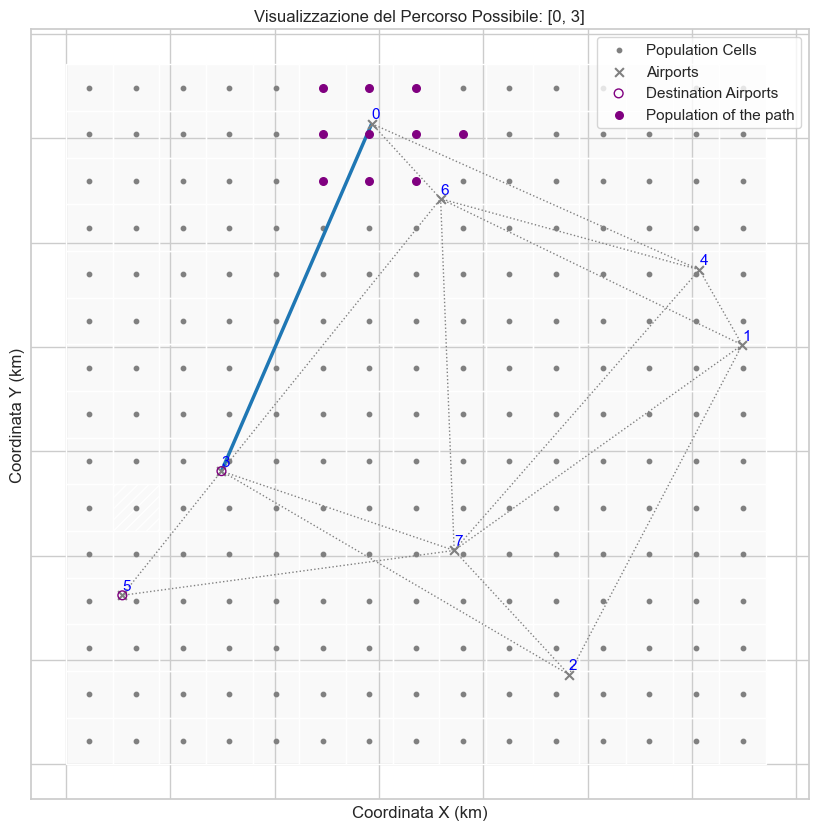

--> Grafico per il percorso 2/26: [0, 3, 5]


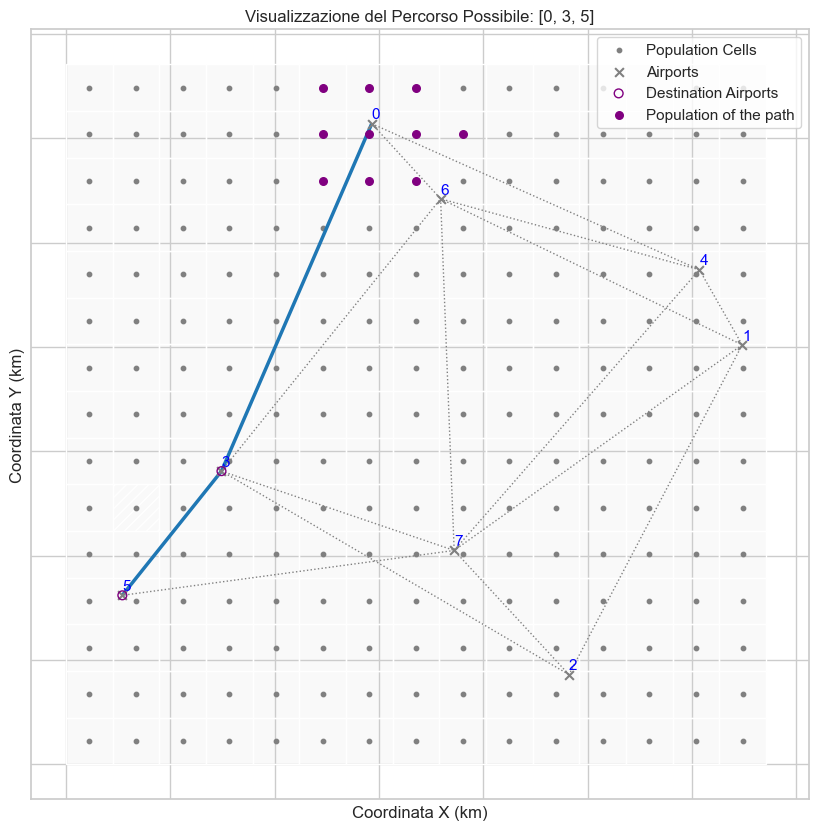

--> Grafico per il percorso 3/26: [0, 6, 3]


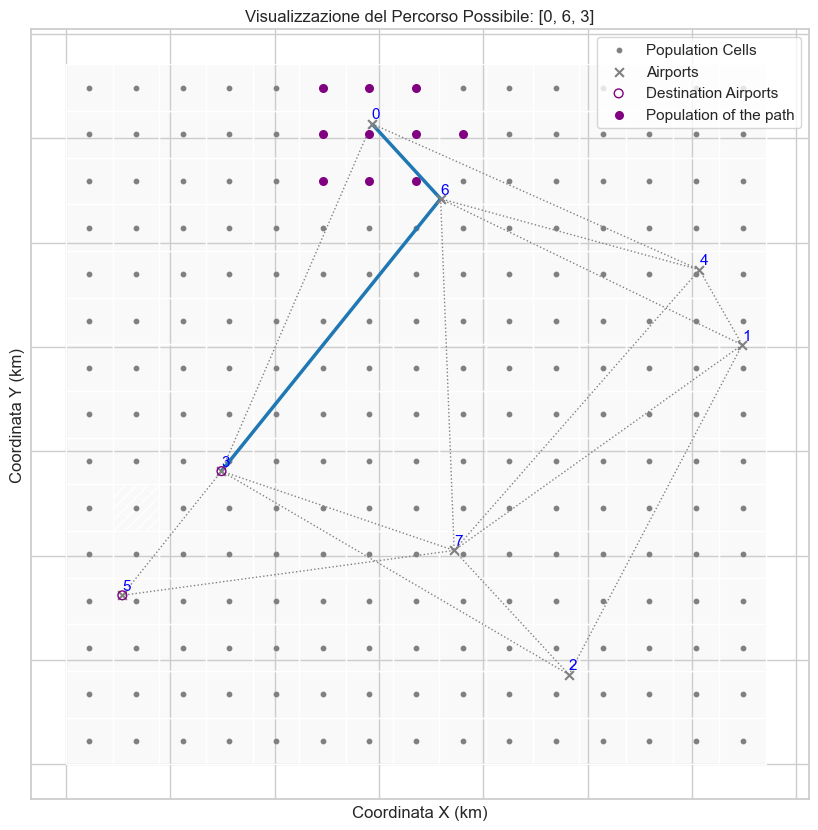

--> Grafico per il percorso 4/26: [4, 0, 3]


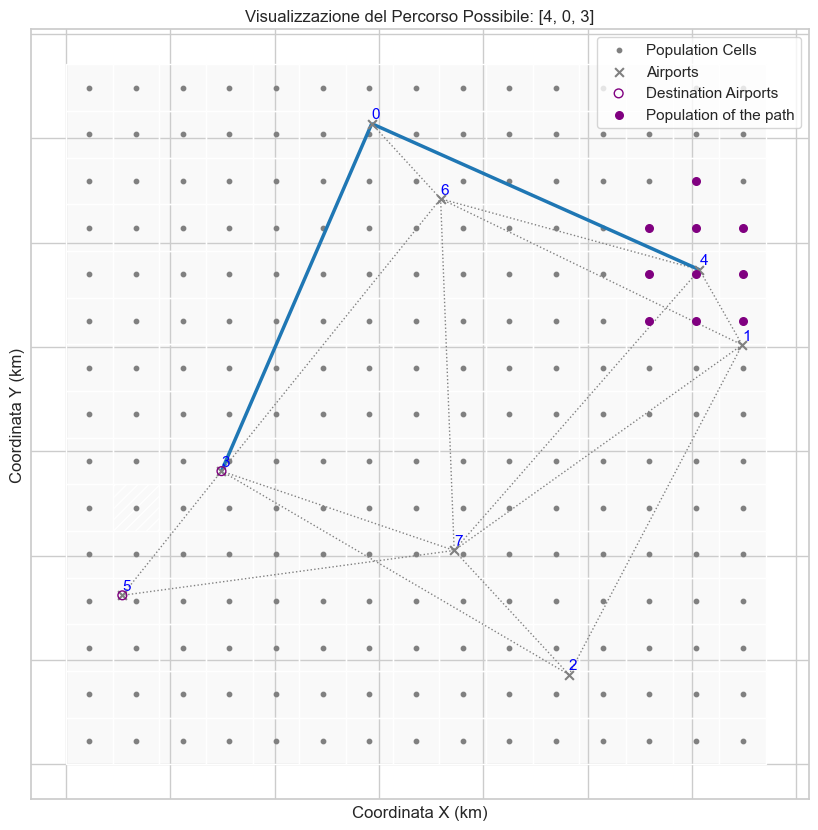

--> Grafico per il percorso 5/26: [4, 6, 3]


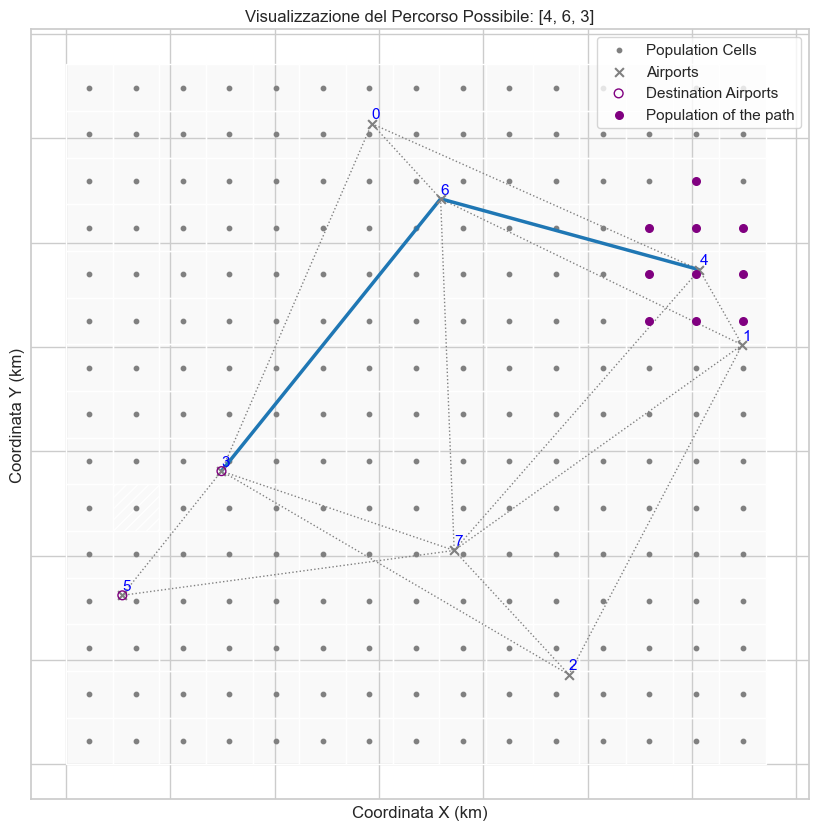

--> Grafico per il percorso 6/26: [4, 7, 3]


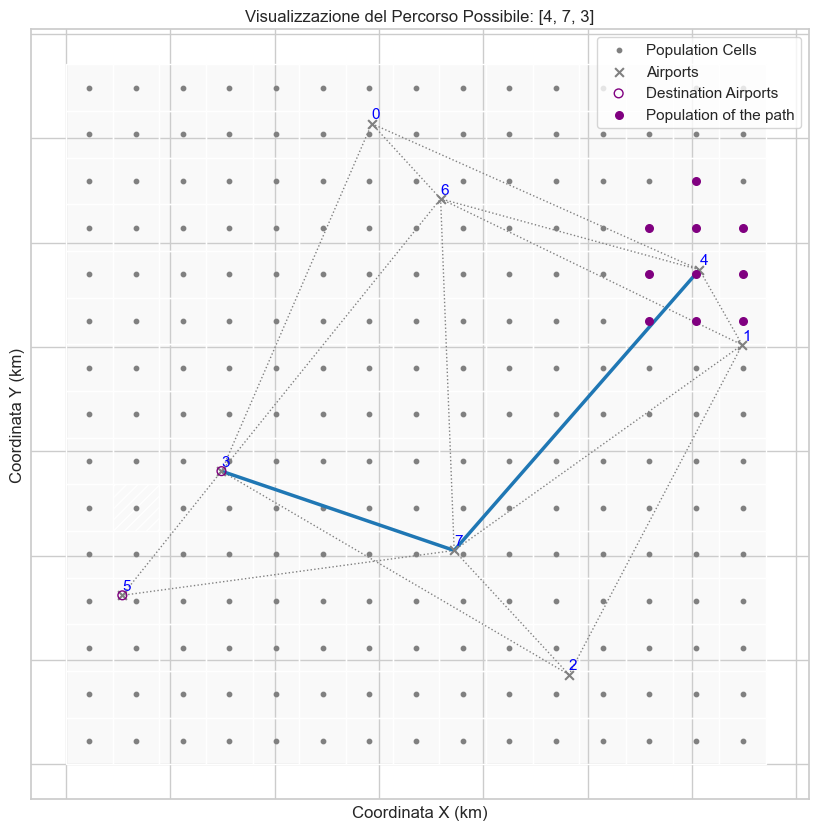

--> Grafico per il percorso 7/26: [4, 7, 5]


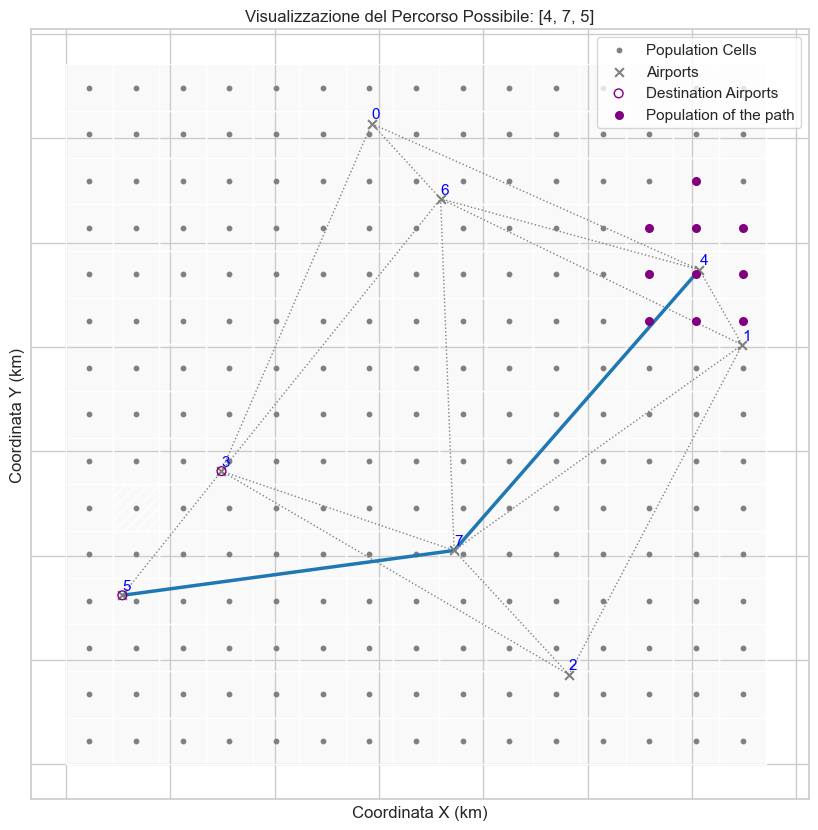

--> Grafico per il percorso 8/26: [6, 0, 3]


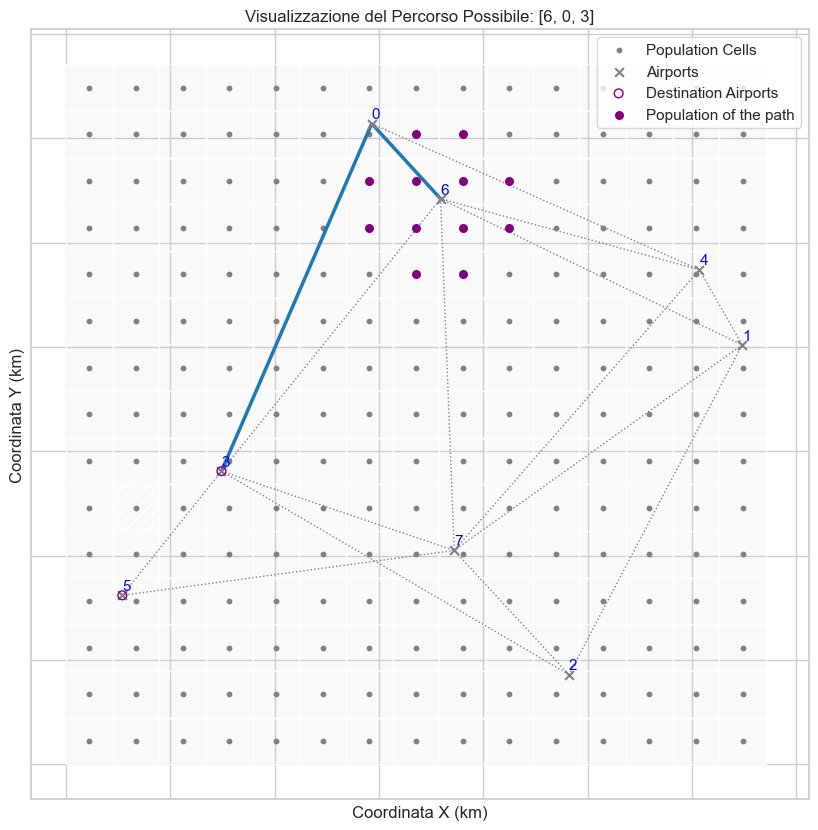

--> Grafico per il percorso 9/26: [6, 3]


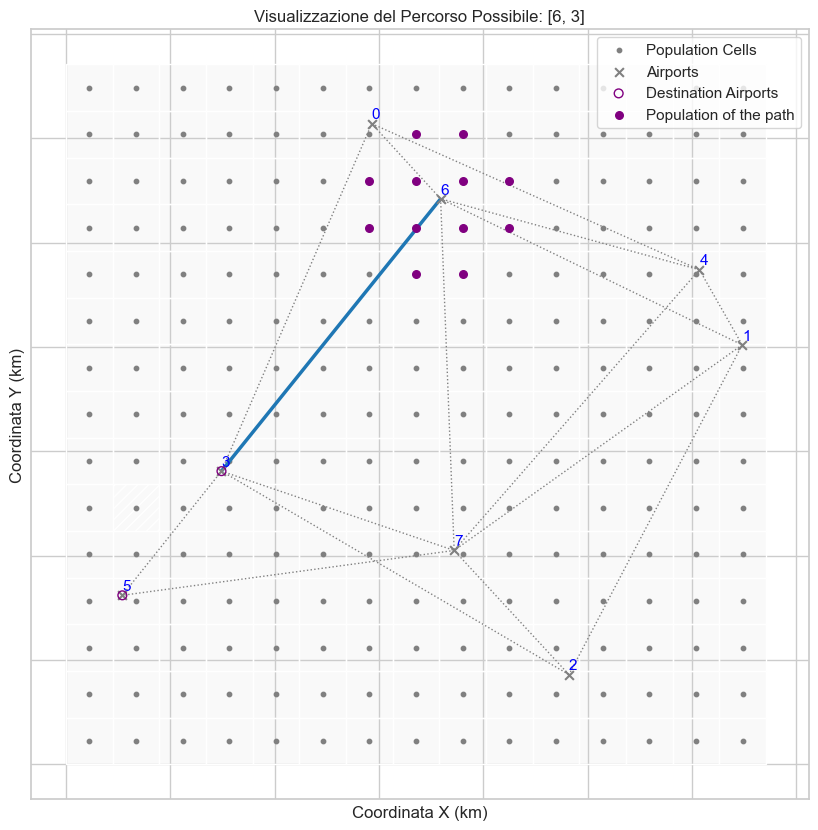

--> Grafico per il percorso 10/26: [6, 3, 5]


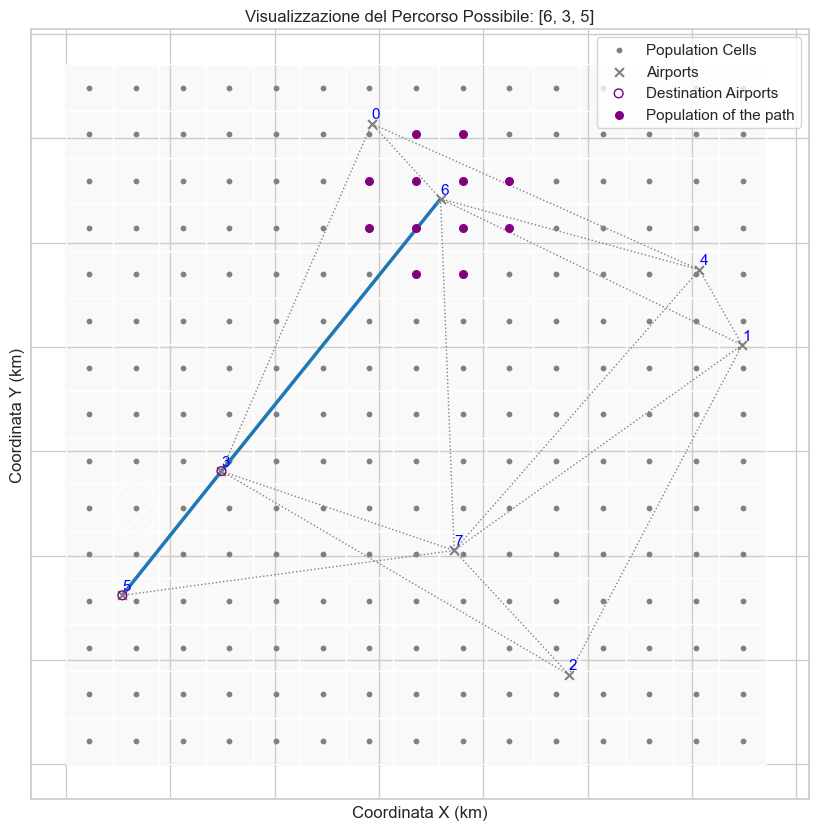

--> Grafico per il percorso 11/26: [6, 7, 3]


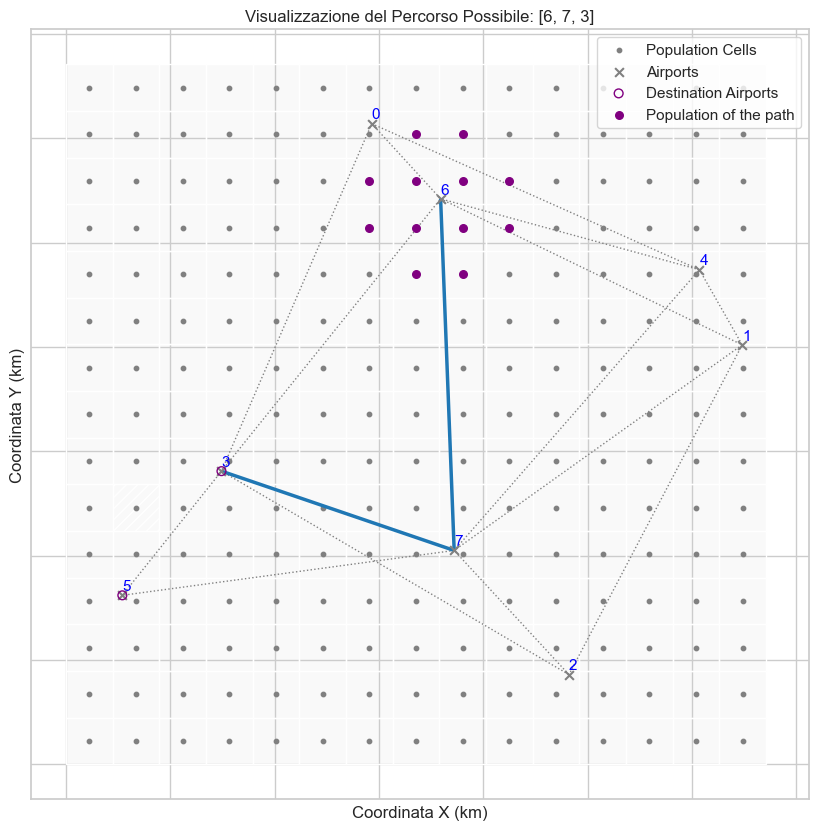

--> Grafico per il percorso 12/26: [6, 7, 5]


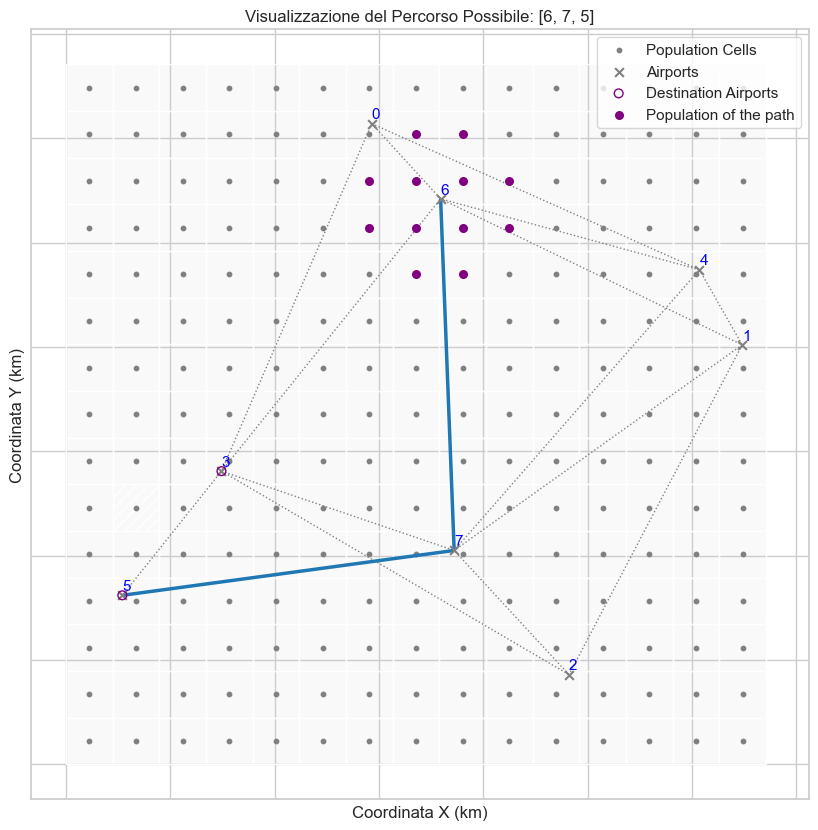

--> Grafico per il percorso 13/26: [1, 2, 3]


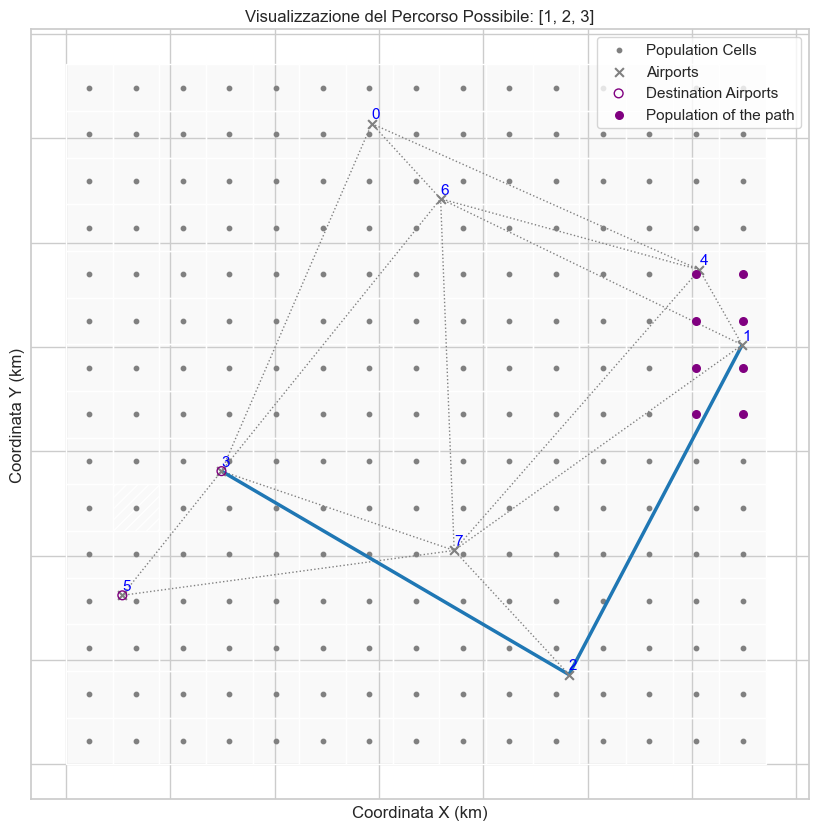

--> Grafico per il percorso 14/26: [1, 6, 3]


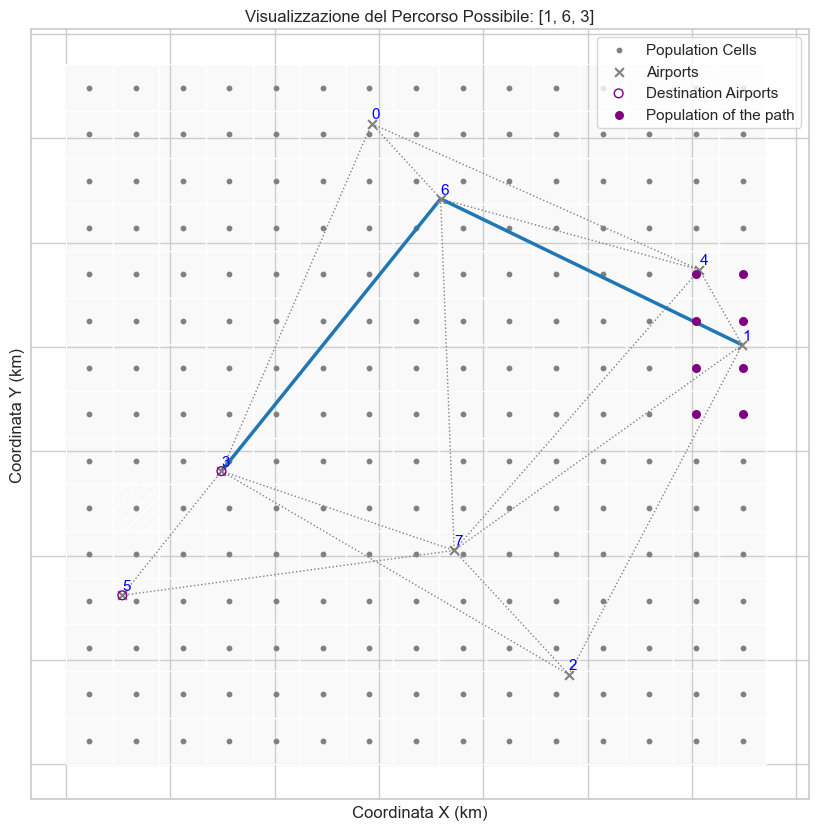

--> Grafico per il percorso 15/26: [1, 7, 3]


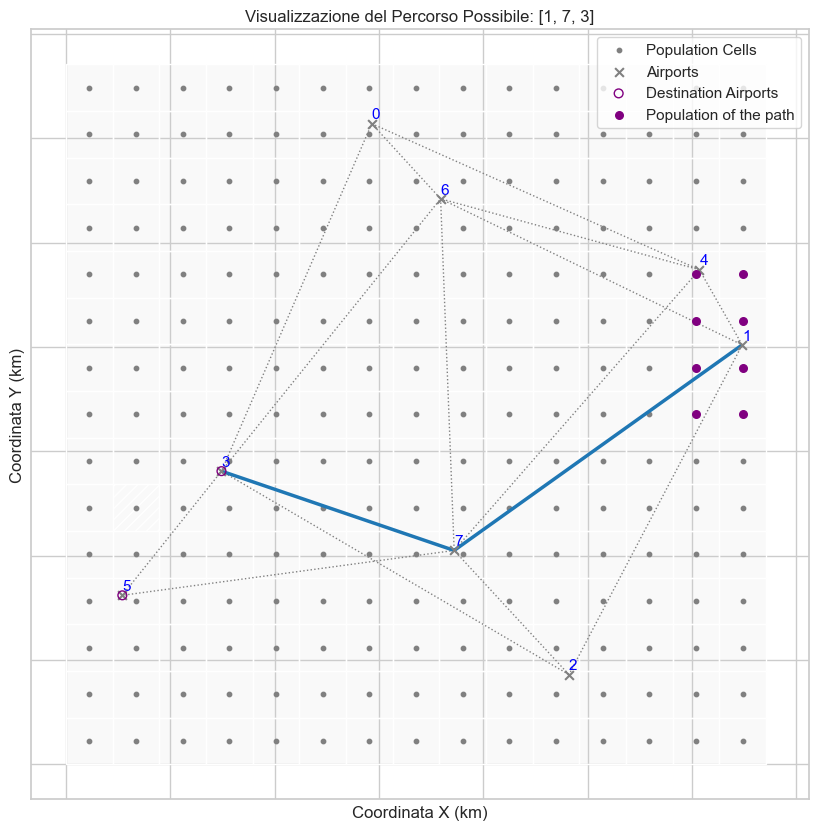

--> Grafico per il percorso 16/26: [1, 7, 5]


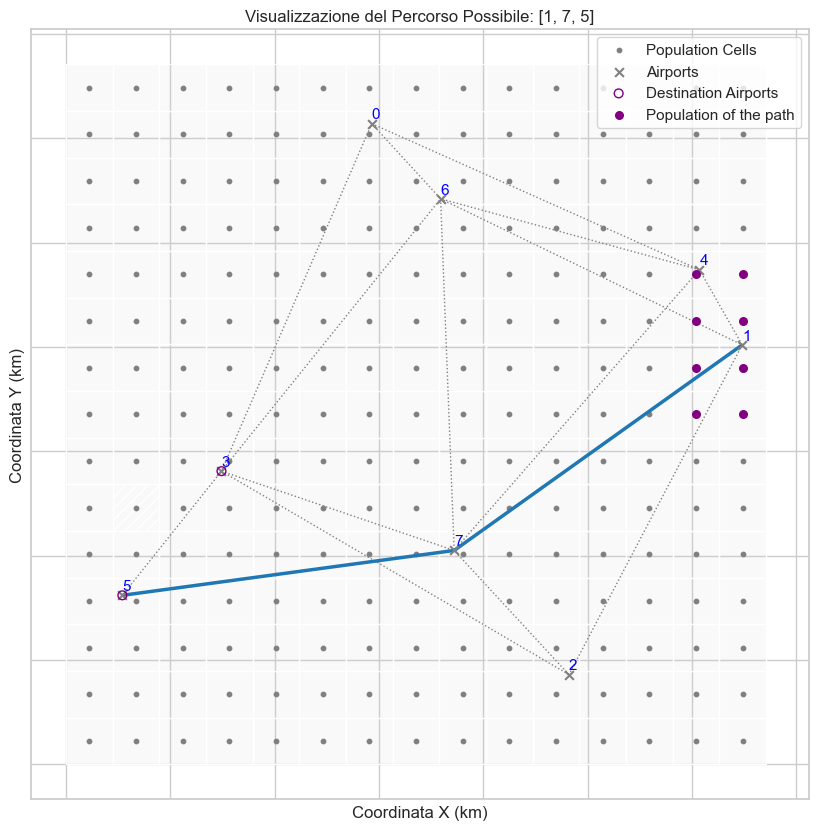

--> Grafico per il percorso 17/26: [2, 3]


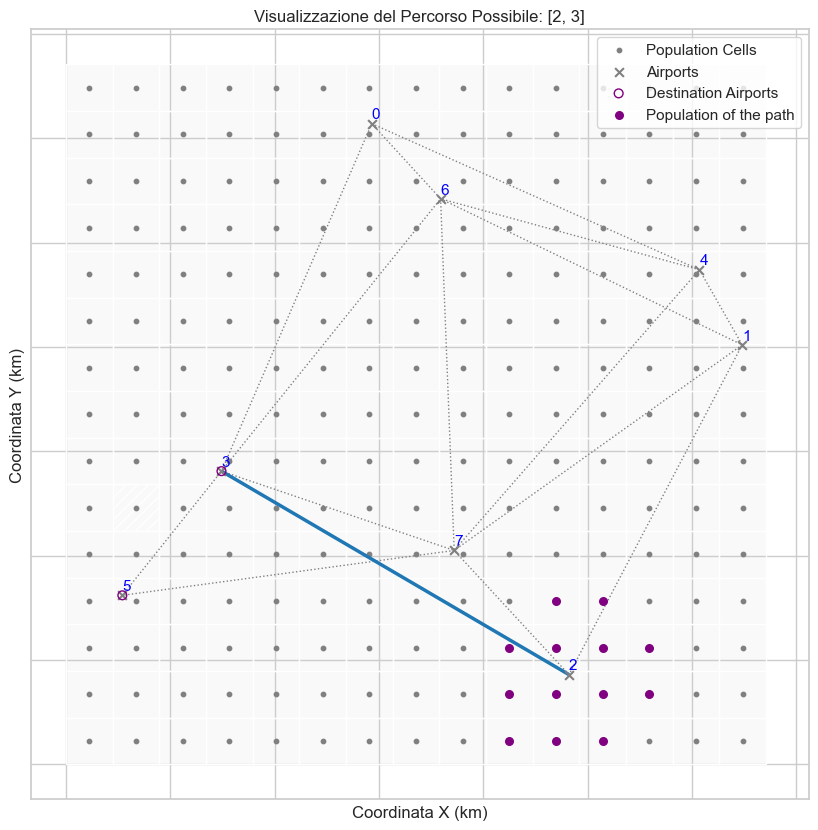

--> Grafico per il percorso 18/26: [2, 3, 5]


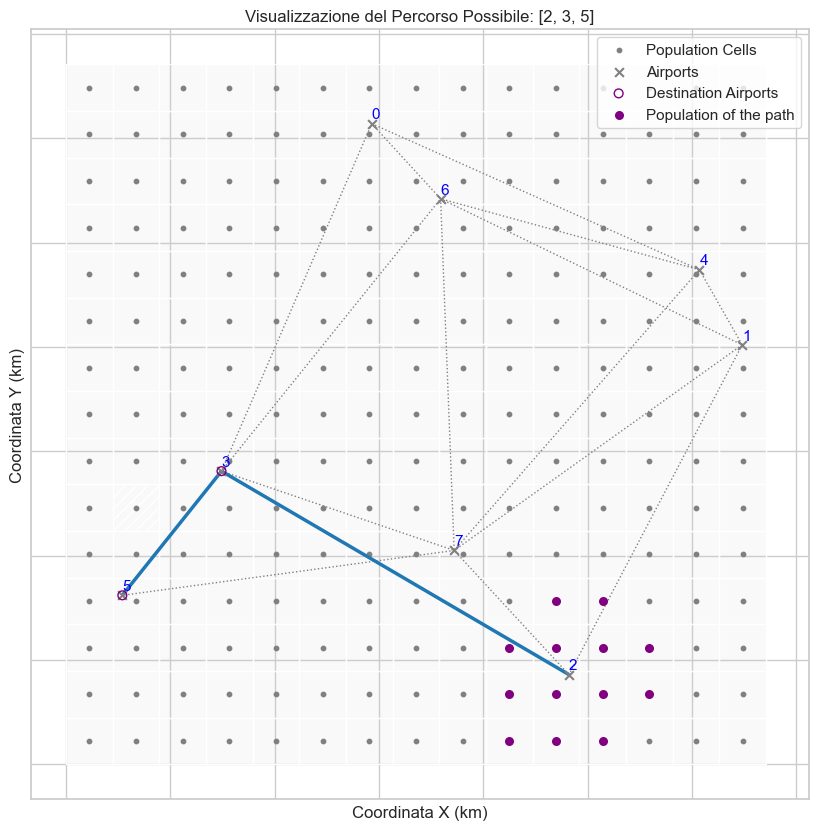

--> Grafico per il percorso 19/26: [2, 7, 3]


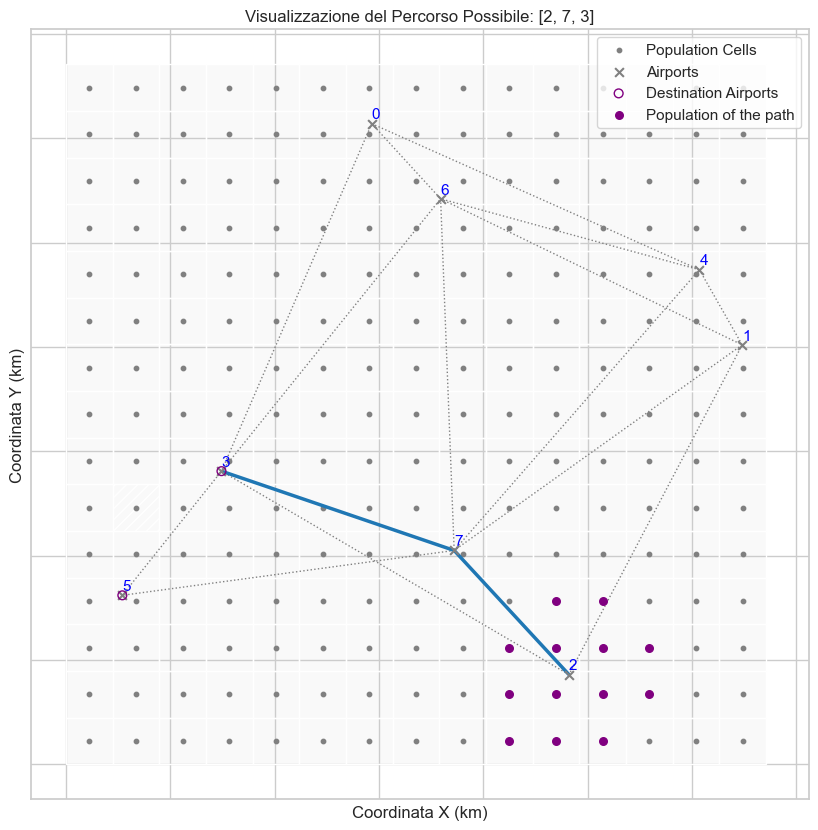

--> Grafico per il percorso 20/26: [2, 7, 5]


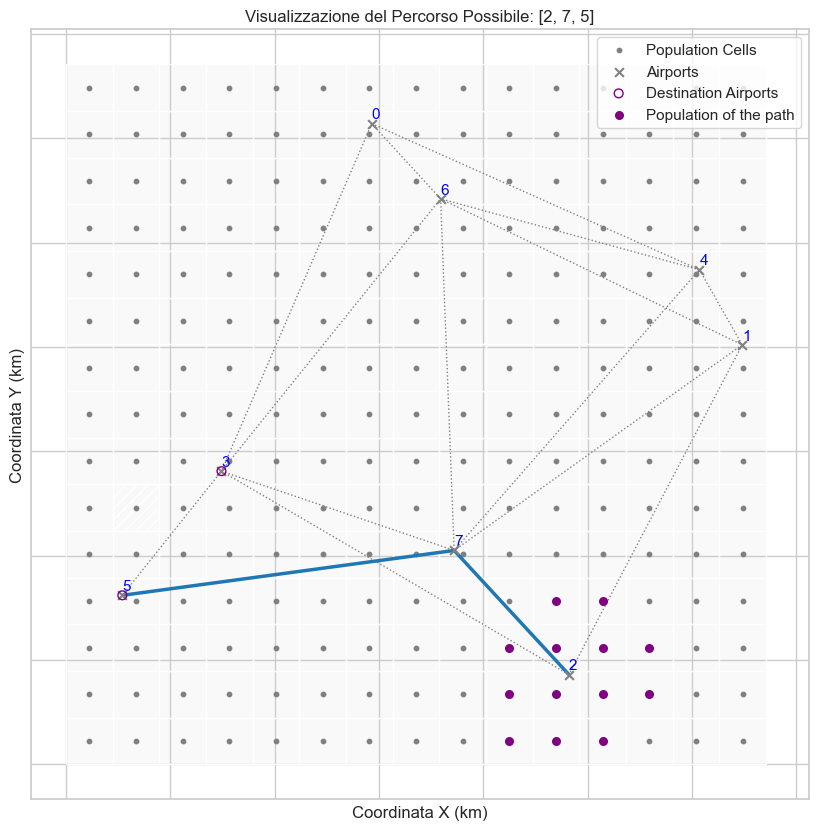

--> Grafico per il percorso 21/26: [7, 2, 3]


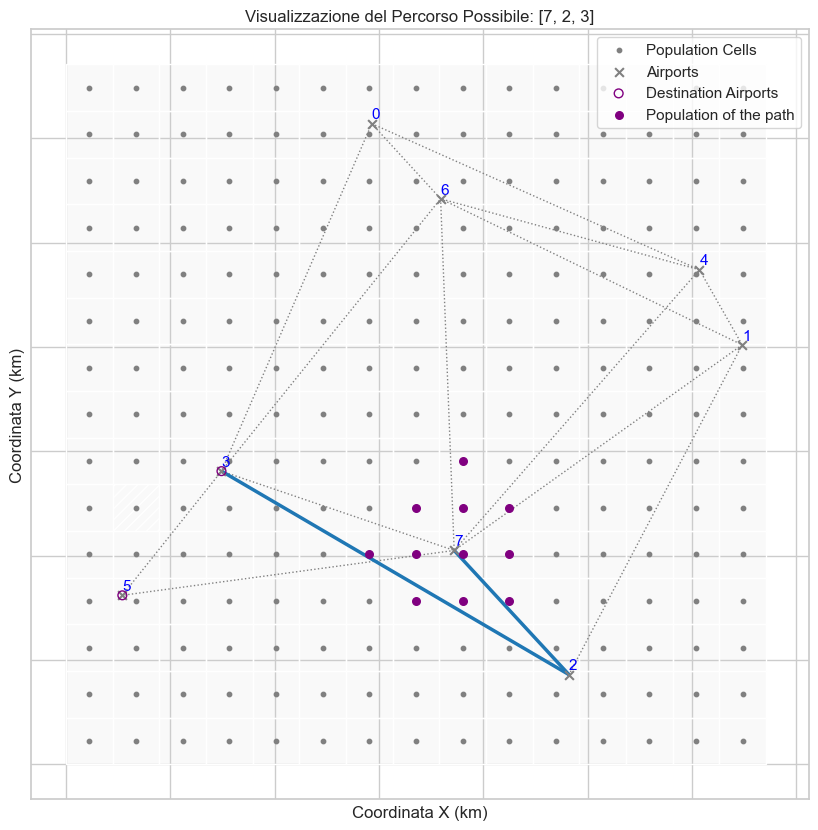

--> Grafico per il percorso 22/26: [7, 3]


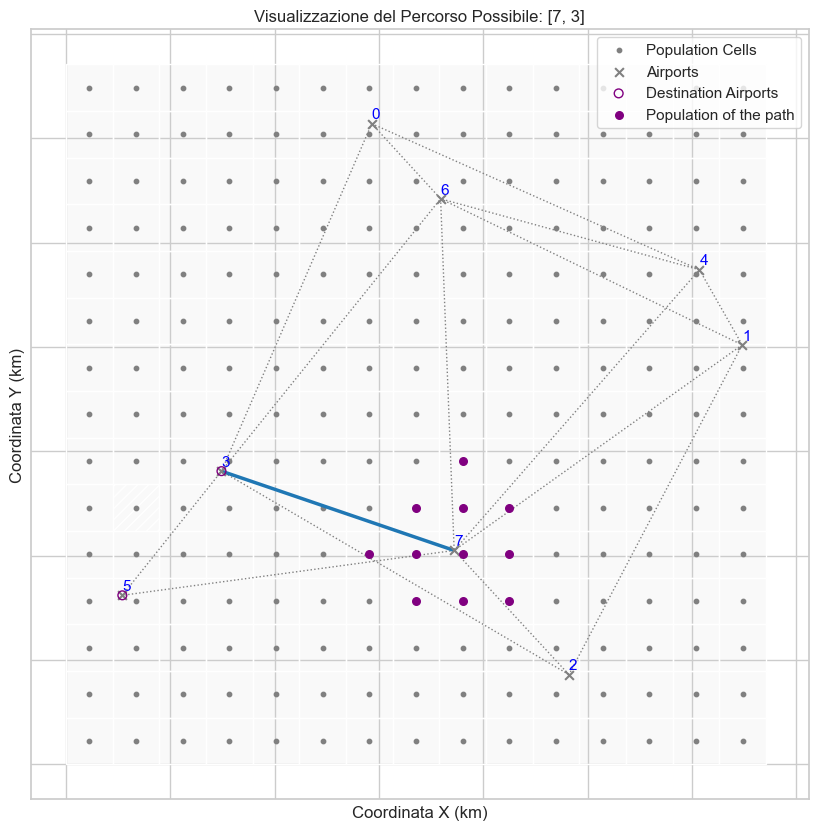

--> Grafico per il percorso 23/26: [7, 3, 5]


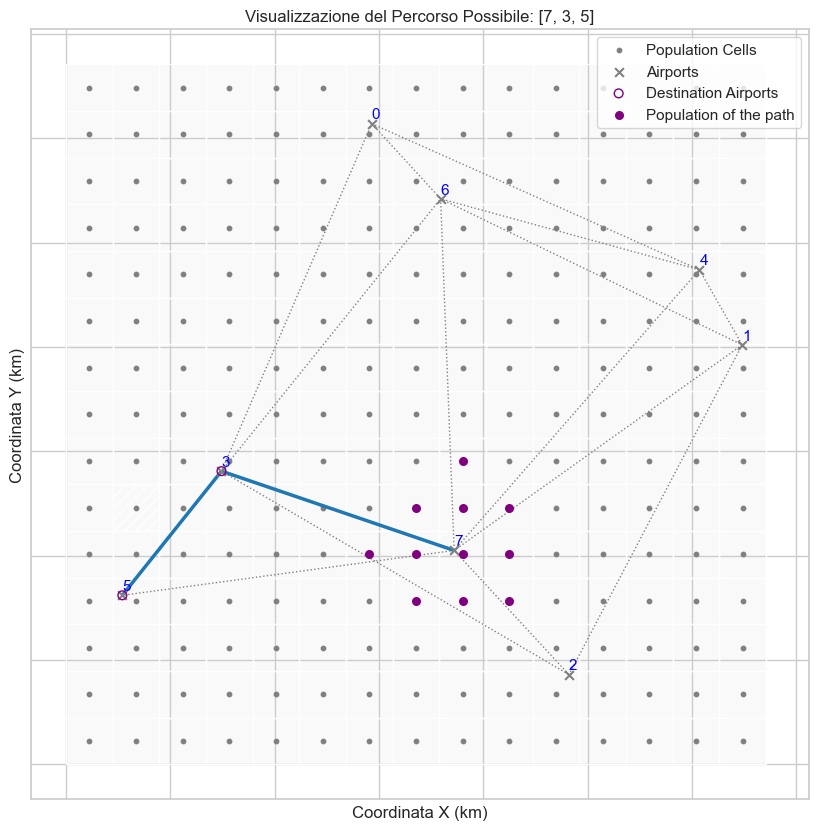

--> Grafico per il percorso 24/26: [7, 5]


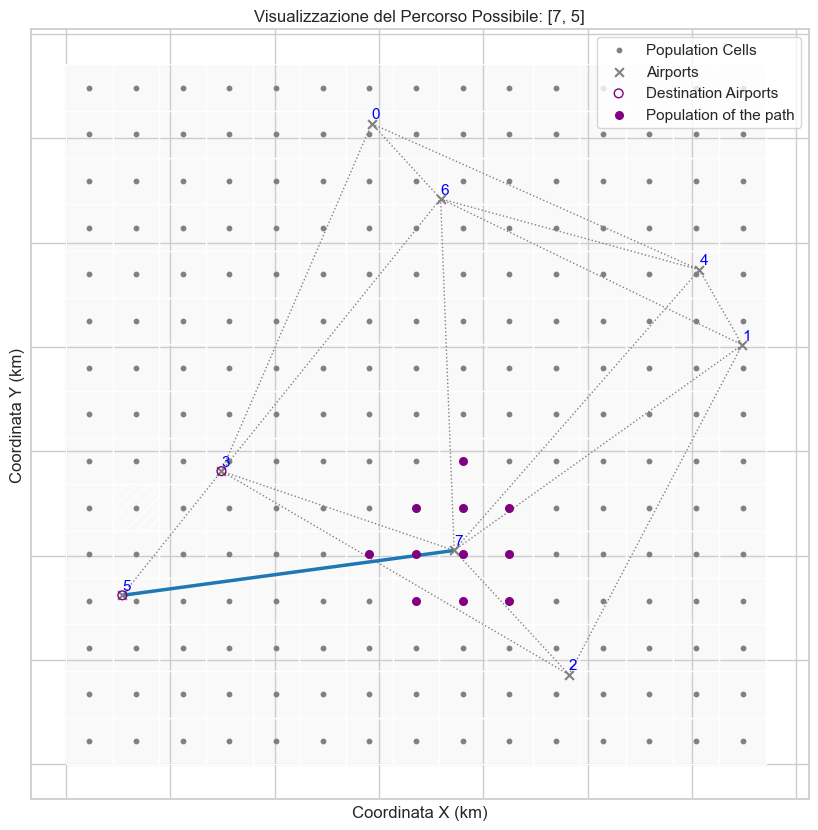

--> Grafico per il percorso 25/26: [7, 5, 3]


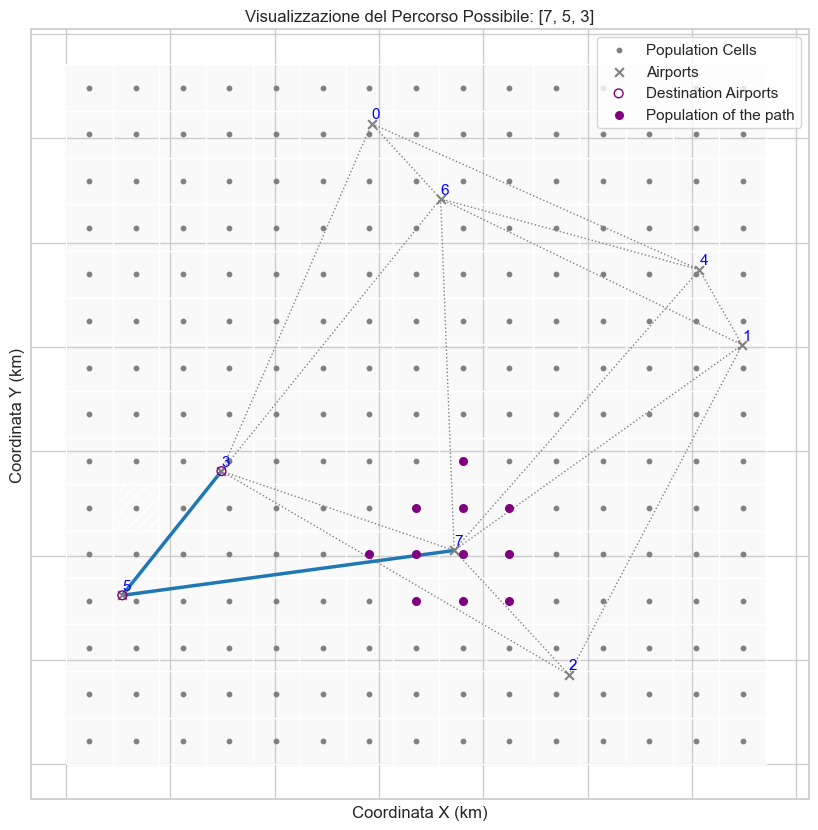

--> Grafico per il percorso 26/26: [7, 6, 3]


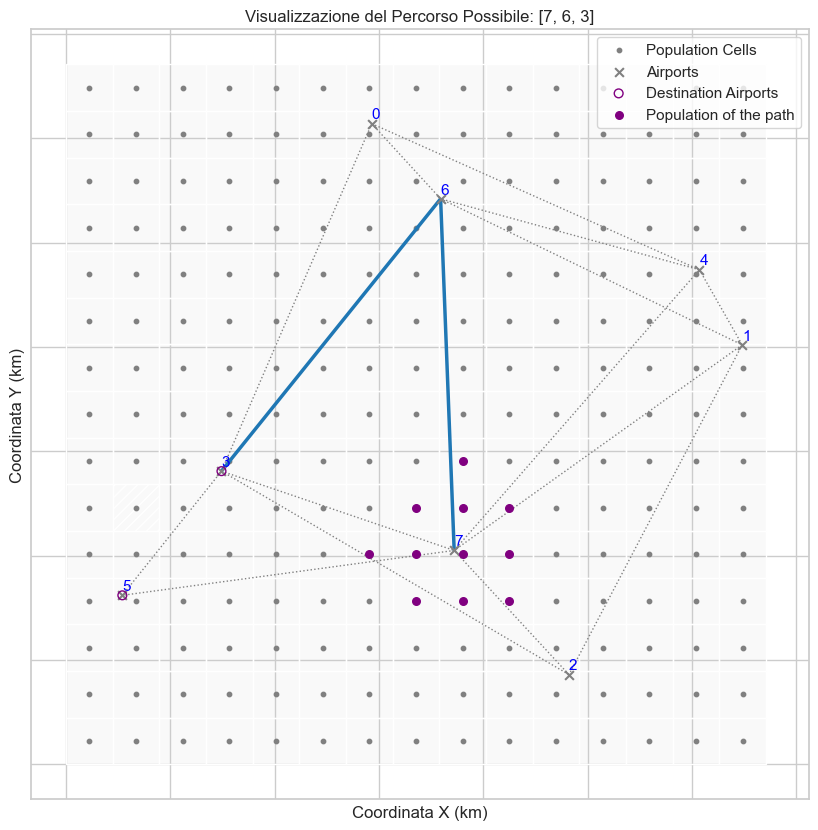

In [ ]:
# ================================================================================
# Cella per visualizzare possible paths
# ================================================================================

from utilis.plot import plot_possible_paths
import matplotlib.pyplot as plt


for i, single_path in enumerate(all_paths):
    print(f"--> Grafico per il percorso {i+1}/{len(all_paths)}: {single_path}")
    
    plot_possible_paths(
        pop_coords=pop_coords,
        airports_coords=airport_coords,
        destination_airports=destination_airports,
        graph=G,
        paths=[single_path], 
        destination_cell=destination_cell,
        pop_paths=pop_to_airport_paths 
    )
    plt.title(f'Visualizzazione del Percorso Possibile: {single_path}')
    plt.show() 




### VISUALIZZAZIONE DEI PERCORSI FATTIBILI NELLA SOLUZIONE OTTIMA ###

### GENERAZIONE DI UN GRAFICO SEPARATO PER OGNUNO DEI 11 PERCORSI DELLA SOLUZIONE ###
--> Grafico per il percorso della soluzione 1/11: [0, 3]


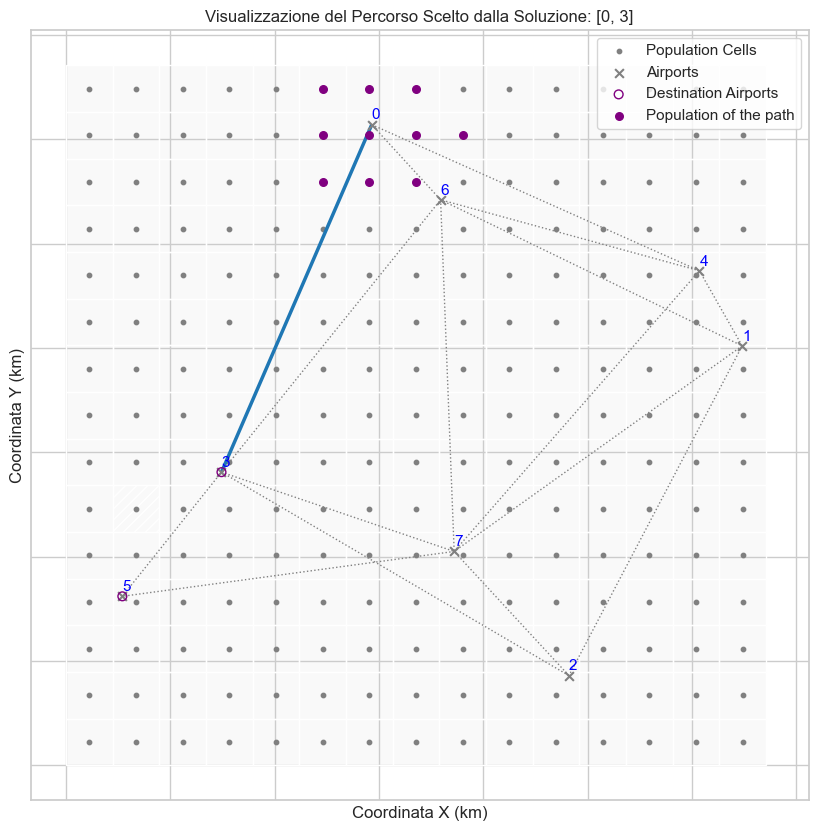

--> Grafico per il percorso della soluzione 2/11: [0, 6, 3]


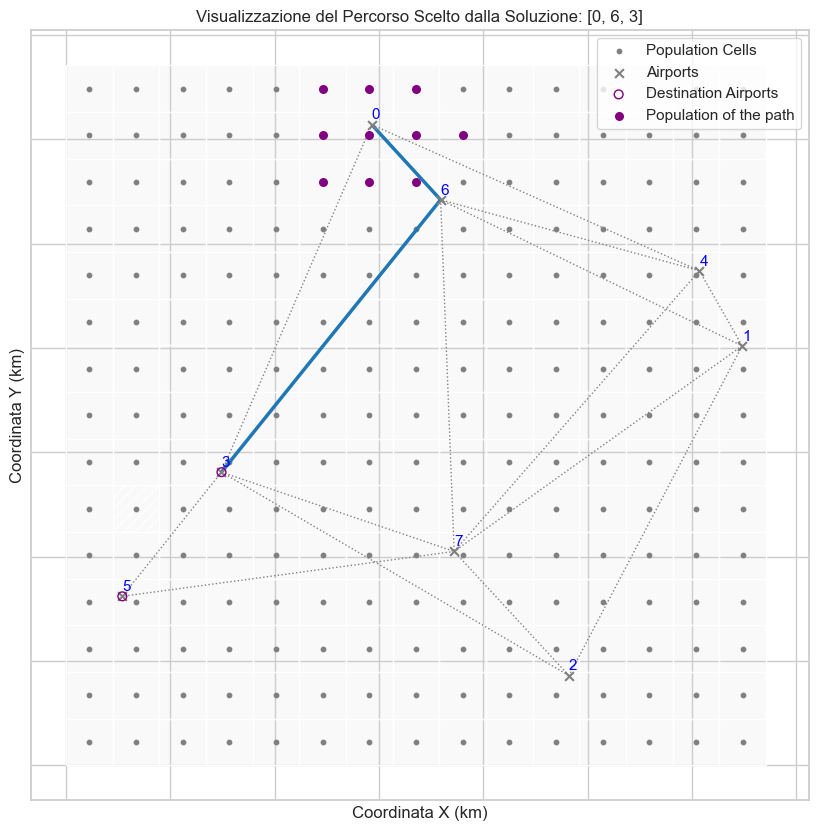

--> Grafico per il percorso della soluzione 3/11: [4, 6, 3]


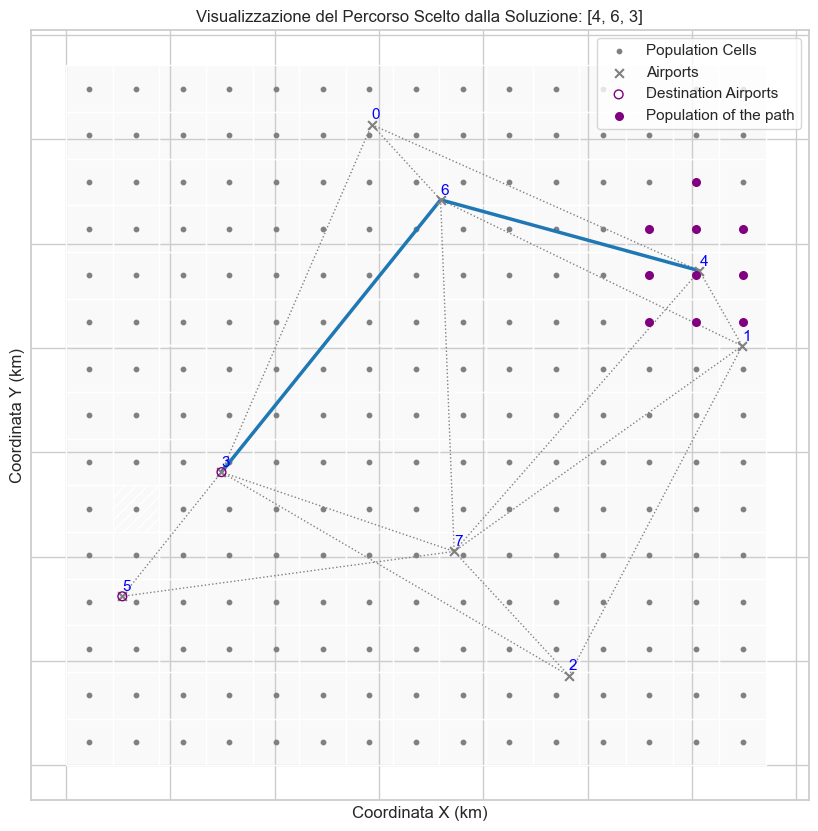

--> Grafico per il percorso della soluzione 4/11: [6, 0, 3]


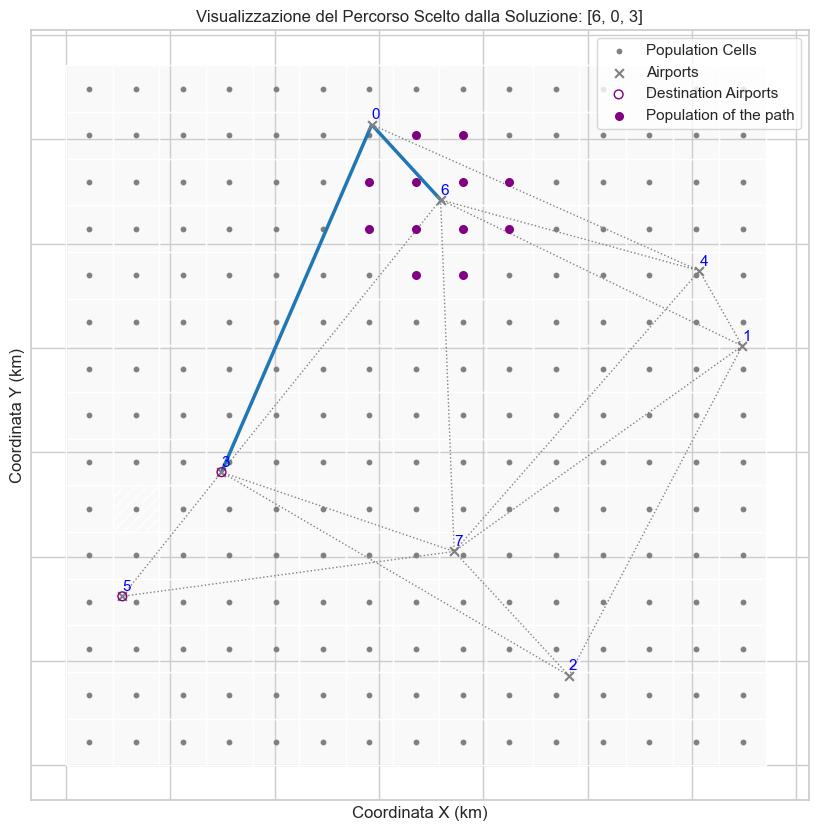

--> Grafico per il percorso della soluzione 5/11: [6, 3]


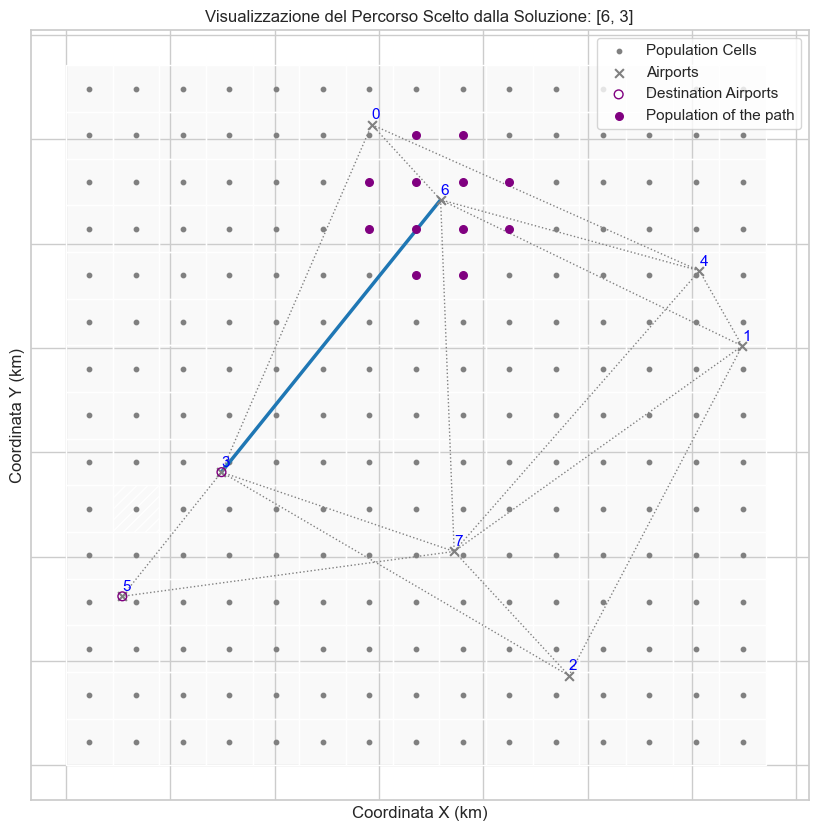

--> Grafico per il percorso della soluzione 6/11: [1, 2, 3]


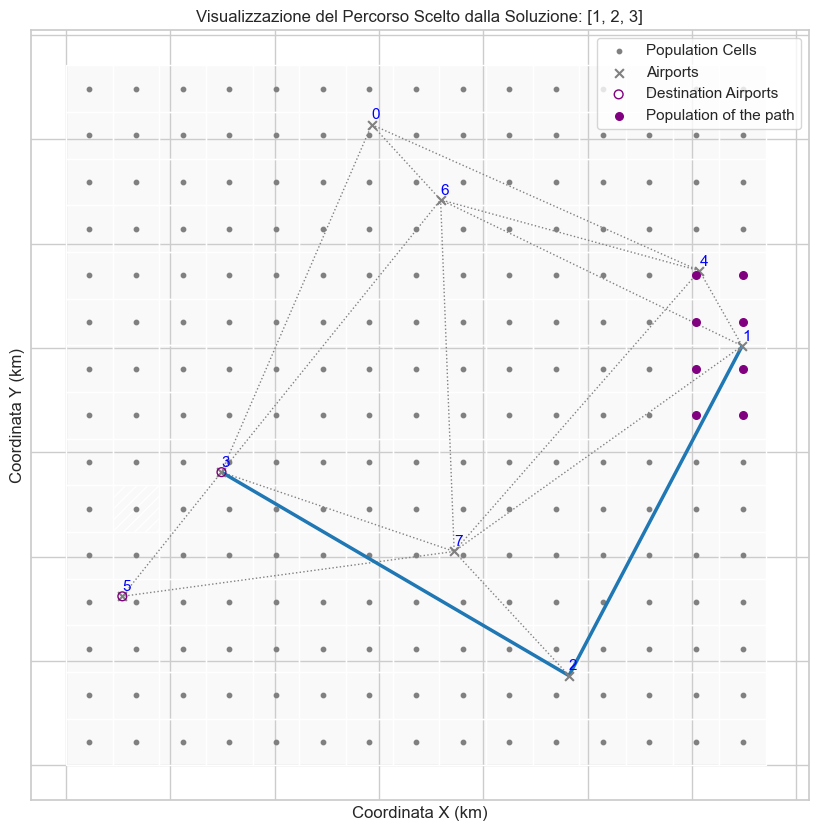

--> Grafico per il percorso della soluzione 7/11: [1, 6, 3]


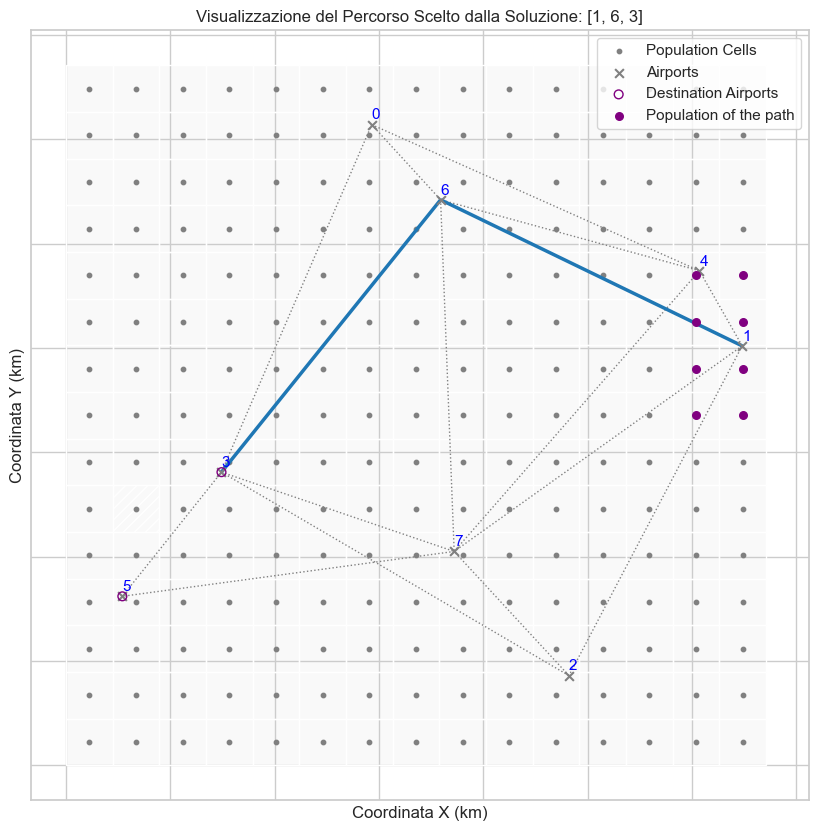

--> Grafico per il percorso della soluzione 8/11: [2, 3]


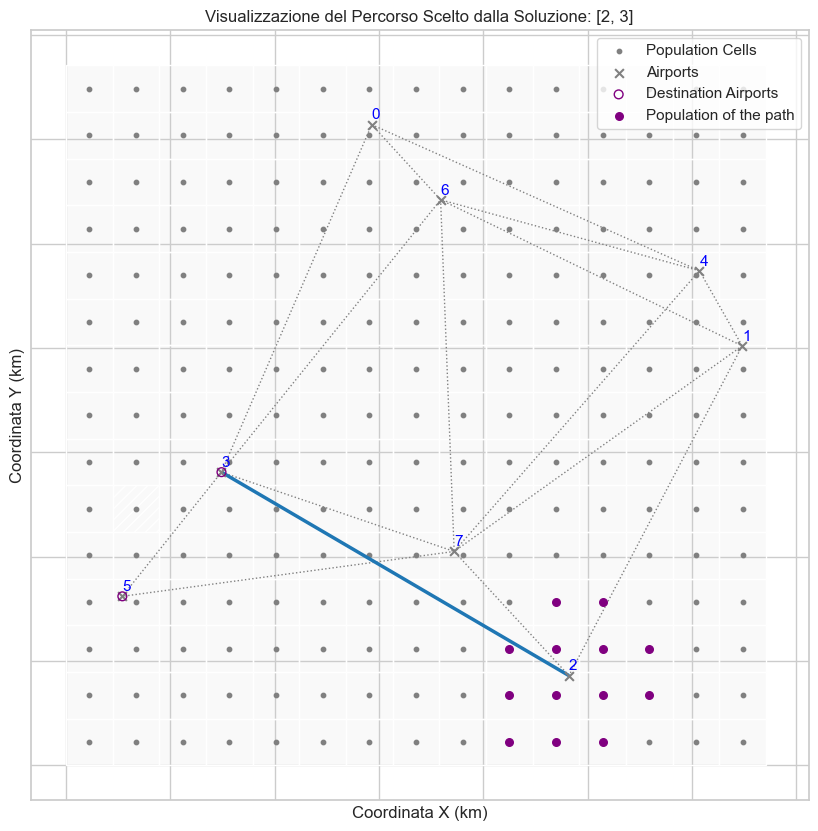

--> Grafico per il percorso della soluzione 9/11: [2, 7, 3]


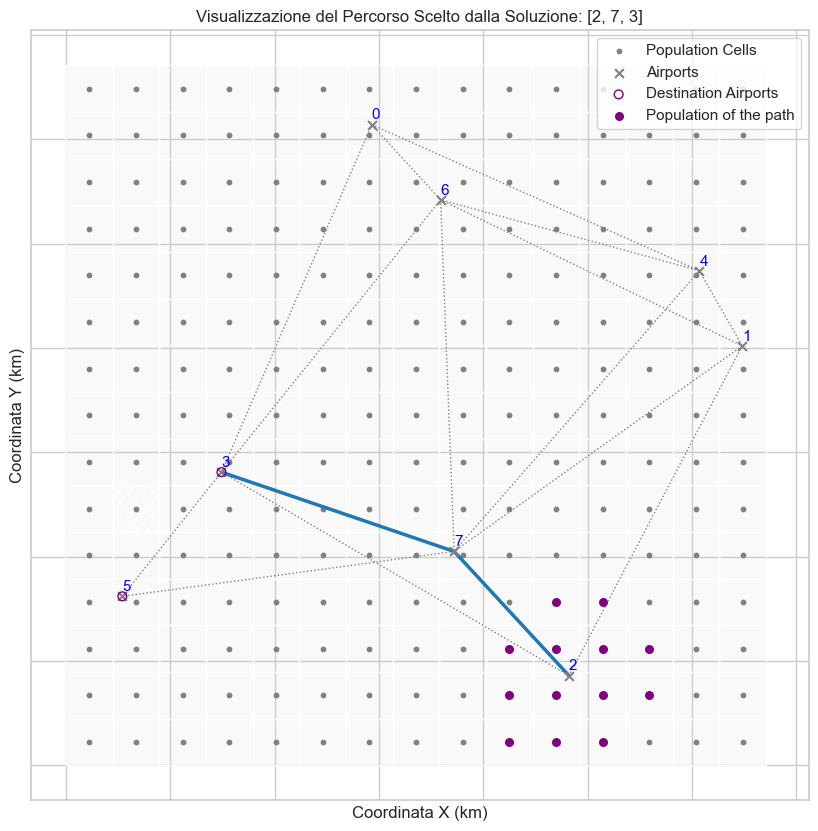

--> Grafico per il percorso della soluzione 10/11: [7, 2, 3]


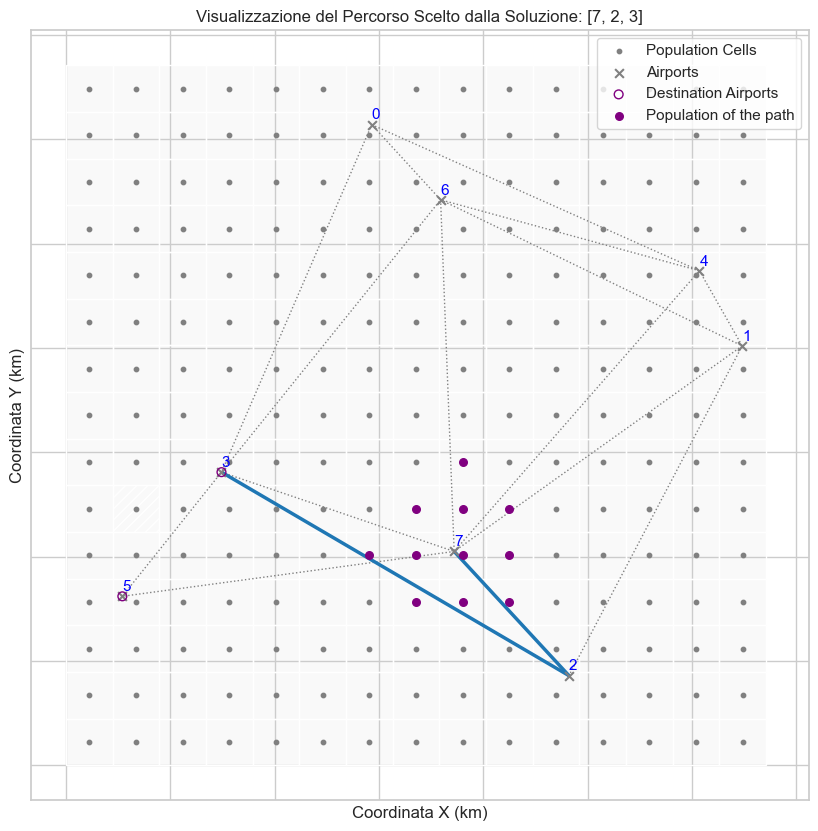

--> Grafico per il percorso della soluzione 11/11: [7, 3]


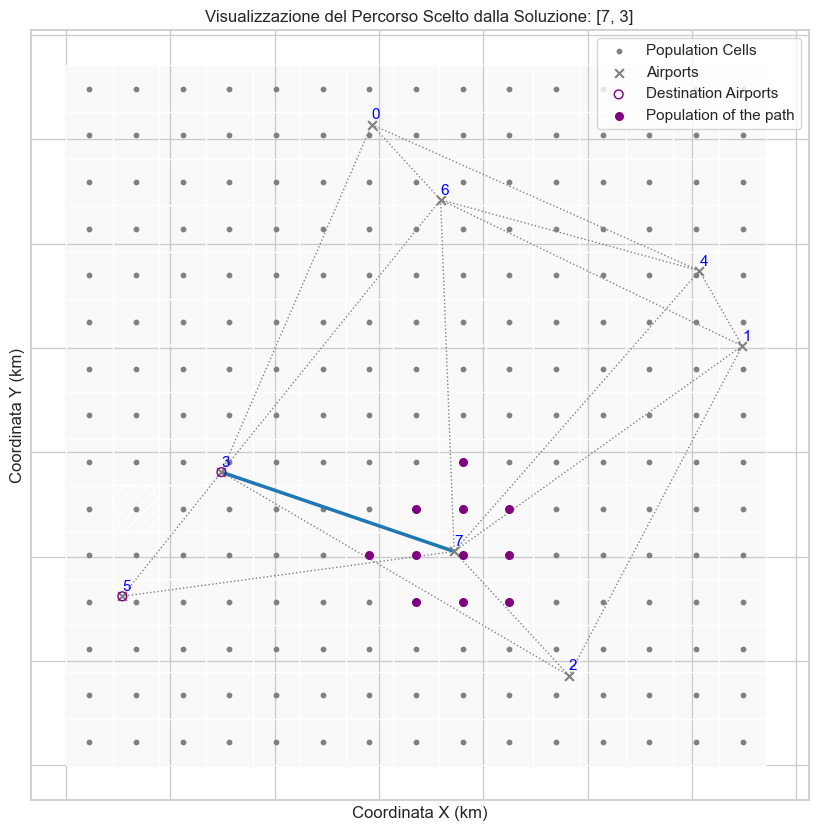

In [70]:
# ====================================================================================
# Cella per visualizzare feasible paths
# ====================================================================================

print("\n### VISUALIZZAZIONE DEI PERCORSI FATTIBILI NELLA SOLUZIONE OTTIMA ###")


if m.Status in (GRB.OPTIMAL, GRB.TIME_LIMIT) and m.SolCount > 0:
    
    all_vars = m.getVars()
    psi_vars = [v for v in all_vars if v.VarName.startswith('psi[')]
    
    active_path_indices = [int(v.VarName[4:-1]) for v in psi_vars if v.X > 0.5]
    solution_paths = [all_paths[i] for i in active_path_indices]
    
    if not solution_paths:
        print("Nessun percorso è risultato fattibile nella soluzione trovata.")
    else:
        print(f"\n### GENERAZIONE DI UN GRAFICO SEPARATO PER OGNUNO DEI {len(solution_paths)} PERCORSI DELLA SOLUZIONE ###")
        
        # --- 2. Ciclo di visualizzazione ---
        for i, single_path in enumerate(solution_paths):
            print(f"--> Grafico per il percorso della soluzione {i+1}/{len(solution_paths)}: {single_path}")

            plot_possible_paths(
                pop_coords=pop_coords,
                airports_coords=airport_coords,
                destination_airports=destination_airports,
                graph=G,
                paths=[single_path],
                destination_cell=destination_cell,
                pop_paths=pop_to_airport_paths
            )
            plt.title(f'Visualizzazione del Percorso Scelto dalla Soluzione: {single_path}')
            plt.show()
else:
    print("Nessuna soluzione valida trovata. Impossibile visualizzare i percorsi.")
